In [1]:
import os
from dotenv import load_dotenv
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
# Load environment variables from .env file
load_dotenv()

# Initialize the Binance exchange object
exchange = ccxt.binance({
    'apiKey': os.getenv('API_KEY'),
    'secret': os.getenv('API_SECRET'),
})

In [3]:
crypto = "AUCTION"
symbol = f'{crypto}/USDT'

start_date = "2023-11-20"
end_date = "2023-12-10"

days = pd.date_range(start=start_date, end=end_date, freq='D').tolist()
days_timestamp = [int(datetime.timestamp(day)) * 1000 for day in days]

df = pd.DataFrame(columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])

for day in days_timestamp:
    ohlcv = exchange.fetch_ohlcv(symbol, since=day, limit=96, timeframe='15m')
    new_df = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
    if not new_df.empty:
        df = pd.concat([df, new_df], ignore_index=True)

df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df['datetime'] += pd.Timedelta(hours=8)
df = df.dropna()
df.set_index('datetime', inplace=True)

C:\Users\alexo\AppData\Local\Temp\ipykernel_31804\2991903458.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


In [4]:
df["hourly"] = np.array([int(s[-8:-6]) for s in df.index.strftime('%Y-%m-%d %H:%M:%S')])
df.to_csv(f"data/{crypto}.csv")

In [5]:
df["Gap (%)"] = (df["close"] / df["open"] - 1) * 100
df

,open,high,low,close,volume,hourly,Gap (%)
datetime,,,,,,,
2023-11-20 00:00:00,8.85,8.90,8.83,8.88,3621.43,0,0.338983
2023-11-20 00:15:00,8.88,8.89,8.83,8.83,1631.77,0,-0.563063
2023-11-20 00:30:00,8.83,8.85,8.81,8.84,1278.22,0,0.113250
2023-11-20 00:45:00,8.82,8.84,8.81,8.83,1005.11,0,0.113379
2023-11-20 01:00:00,8.82,8.87,8.82,8.85,1372.55,1,0.340136
...,...,...,...,...,...,...,...
2023-12-10 00:30:00,17.03,17.19,17.03,17.14,4503.16,0,0.645919
2023-12-10 00:45:00,17.11,17.18,17.08,17.16,1958.15,0,0.292227
2023-12-10 01:00:00,17.15,17.15,16.82,16.88,7630.96,1,-1.574344


In [6]:
df_hourly = pd.DataFrame(df[["hourly", "Gap (%)"]])
df_hourly = df_hourly.groupby("hourly")["Gap (%)"].mean()
df_hourly = pd.DataFrame(df_hourly)
df_hourly

,Gap (%)
hourly,
0,0.272370
1,-0.112338
2,0.128837
3,-0.023935
4,-0.002467
5,0.034903
6,-0.140116
7,-0.139341
8,0.217117


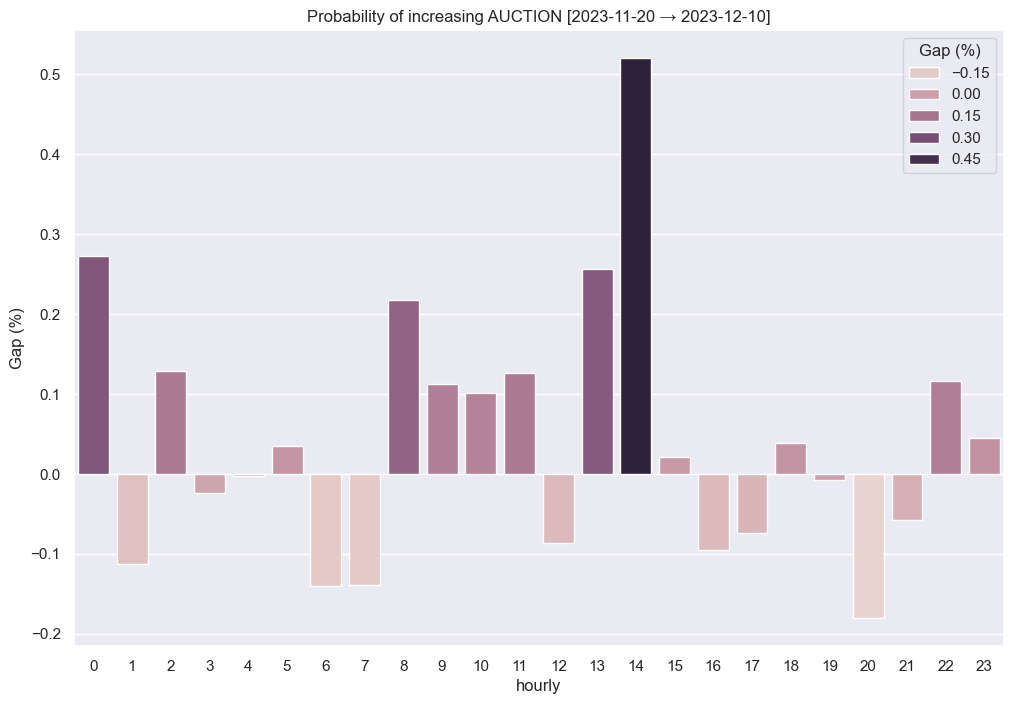

In [7]:
plt.figure(figsize=(12,8))
sns.barplot(df_hourly, x="hourly", y="Gap (%)", hue="Gap (%)")
plt.title(f"Probability of increasing {crypto} [{start_date} → {end_date}]")
plt.show()

In [8]:
df_hourly_chg_beta = pd.DataFrame(df[["hourly", "Gap (%)"]])
df_hourly_chg_beta["Changement +"] = df_hourly_chg_beta["Gap (%)"] > 0
df_hourly_chg = pd.DataFrame(df_hourly_chg_beta.groupby("hourly")["Changement +"].sum())
df_hourly_chg["Changement -"] = (df_hourly_chg_beta.groupby("hourly")["Changement +"].count()
                                 - df_hourly_chg_beta.groupby("hourly")["Changement +"].sum())

df_hourly_chg["Changement +"] /= df_hourly_chg_beta.groupby("hourly")["Gap (%)"].count()
df_hourly_chg["Changement -"] /=df_hourly_chg_beta.groupby("hourly")["Gap (%)"].count()

df_hourly_chg["Changement +"] *= 100
df_hourly_chg["Changement -"] *= 100

df_hourly_chg = df_hourly_chg.reset_index()
df_hourly_chg = pd.melt(df_hourly_chg, id_vars=['hourly'], var_name='Changement', value_name='num_changement (%)')
df_hourly_chg

,hourly,Changement,num_changement (%)
0,0,Changement +,51.190476
1,1,Changement +,37.349398
2,2,Changement +,51.250000
3,3,Changement +,45.000000
4,4,Changement +,45.000000
5,5,Changement +,53.750000
6,6,Changement +,43.750000
7,7,Changement +,40.000000
8,8,Changement +,47.500000
9,9,Changement +,47.500000


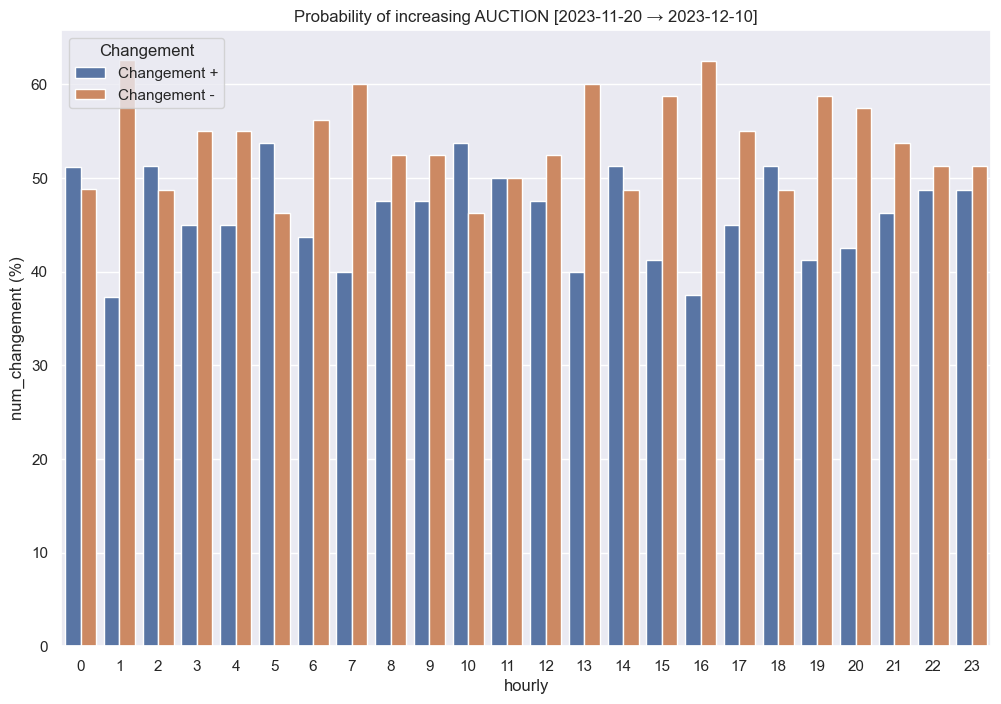

In [9]:
plt.figure(figsize=(12,8))
sns.barplot(df_hourly_chg, x="hourly", y="num_changement (%)", hue="Changement")
plt.title(f"Probability of increasing {crypto} [{start_date} → {end_date}]")
plt.show()